# Accessing the GMF components

In this tutorial, we show how to access the different magnetic field components of the models of the Galactic magnetic field from <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a> and <a href="https://ui.adsabs.harvard.edu/abs/2011ApJ...738..192P/abstract">Pshirkov et al. (2011)</a>.

We begin with the necessary importants and defining a grid in galacto-centric coordinates.

In [1]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt

First we build 3D coordinate arrays in galactocentric cartesian ($x, y, z$) and cylindrical coordinates $(\rho, \phi, z)$, where $x, y, z$ and $\rho$ are in units of kpc. 

In [2]:
x = np.linspace(-20.,20.,300)
y = np.linspace(-20.,20.,300)
z = np.arange(-5.,5.01,0.01)
xx, yy, zz = np.meshgrid(x, y, z, indexing = 'ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

## The Pshirkov model

For the Pshirkov model, both the bisymmetric (BSS) and the axisymmetric (ASS) versions are available.
We iilustrate the model and its usage for the ASS version.

The model is simply initialized like this:

In [3]:
pshirkov = gmf.GMFPshirkov(model='ASS')

The model has to $B$-field components: the field in the halo and in the disk. To show the disk component, we select the $z$ component that is closest to $z=0$:

In [4]:
idz = np.argmin(np.abs(z))

Then we calculate and plot the disk component through the `Bdisk` function. 
We multiply the abolute value of the field with the `gmf.signum` function to determine the sign of the $B$-field relative to the $z=0$ plane.

In [5]:
Bdisk = np.zeros_like(rr[...,idz])

for i, r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is absolute value
    b = pshirkov.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

And plot the results:

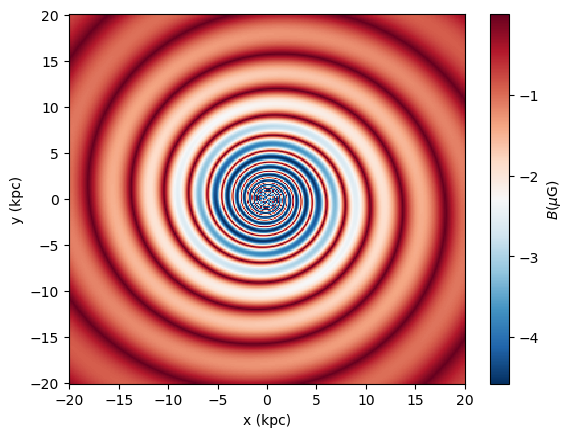

In [6]:
im = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

We proceed similarly for the halo component by finding the index where $y = 0$ (or closest to it):

In [7]:
idy = np.argmin(np.abs(y))

And calculate the halo component in the same way as the disk component:

In [8]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

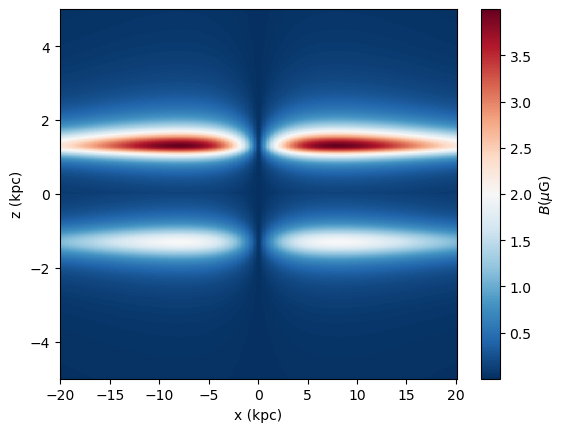

In [9]:
im = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

The total magnetic field would then be found by summing the `Bdisk` and `Bhalo` vectors (evaluated over the same coordinate grid). 

## The Jansson & Farrar model

We follow the same steps for the Jansson & Farrar model. The only difference here is that this model has an additional "X" component which we will plot as well. 

We initiate the class like this:

In [10]:
jansson = gmf.GMF()

Print the magnetic field in the 8th ring, which is given by $b_8 = \sum_{i=1}^7 b_i f_i / f_8$, where the $f_i$ is relative cross-sectional areas of the spirals (for a fixed radius) and $b_i$ is the mangetic field in each spiral arm (see <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a>, Sec. 5.1.1).

In [11]:
print (jansson.b[7])

2.755128205128205


Now calculate the disk component:

In [12]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    b = jansson.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

And for some specific positions, at which we want to place arrows in the plot

In [13]:
# position of arrows in plot
rho0 = np.array([4., 5.5, 6.5, 8., 9., 10.5, 12, 16.5])
phi0 = np.array([5. * np.pi / 4.])

Bdisk_arrow = np.zeros([3, rho0.size])
for i, r in enumerate(rho0):
    b = jansson.Bdisk(np.array([r]), phi0, z=z[idz])[0]
    Bdisk_arrow[:,i] = b[:,0]
    
# now transform Bdisk_arrow components (rho, phi, z)
# to cartesian coordinates
Bdisk_x = np.zeros_like(Bdisk_arrow)  # disk component in cartesian coordinates
Bdisk_x[0] = np.cos(phi0) * Bdisk_arrow[0] - np.sin(phi0) * Bdisk_arrow[1]
Bdisk_x[1] = np.sin(phi0) * Bdisk_arrow[0] + np.cos(phi0) * Bdisk_arrow[1]
Bdisk_x[2] = Bdisk_arrow[2]

Plotting it:

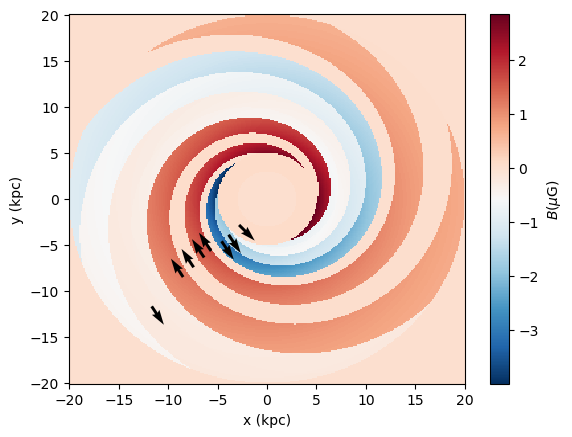

In [14]:
im = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap=plt.cm.RdBu_r, shading='auto')

# the arrows
plt.quiver(rho0 * np.cos(phi0), rho0 * np.sin(phi0),
           Bdisk_x[0] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
           Bdisk_x[1] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
          )

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

Proceeding with the halo component in the same way as before:

In [15]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

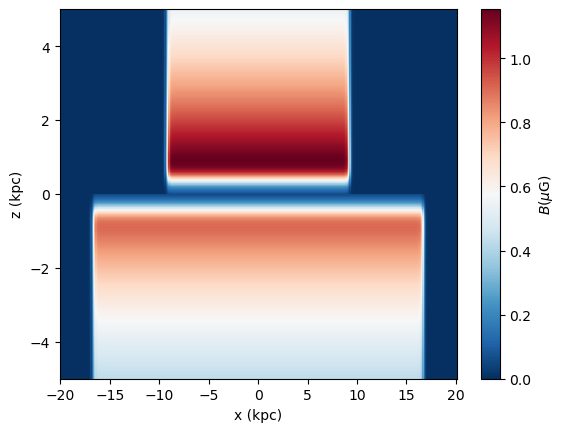

In [16]:
im = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

And the additional "X" component:

In [17]:
BX_abs = np.zeros_like(xx[:,idy,:])
BX = np.zeros([3] + list(xx[:,idy,:].shape))

for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.BX(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]
    
# now transform Bdisk_arrow components (rho, phi, z)
# to cartesian coordinates
# note that phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])

BX_z = BX[2]

/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_84724/2324834406.py:8: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_84724/2324834406.py:15: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],


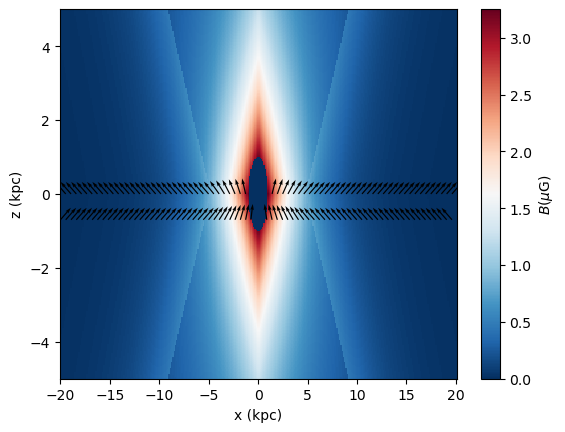

In [18]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=plt.cm.RdBu_r, shading='auto')

# plot the arrows
# at z = 0
idz = int(len(z) / 2)
step = 4
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

# arrows below disk
idz = int(len(z) / 2) - 70
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

Again, the total magnetic field would be found by summing the `Bdisk`, `Bhalo`, and `BX` vectors evaluated over the same coordinate grid. 